# Gender recognition

In [1]:
!pip install pandas
!pip install sklearn
!pip install scipy

In [2]:
!rm -rf data
!mkdir data
%cd data
!wget "http://datax.kennesaw.edu/imdb_wiki/imdb4p5.csv"
%cd ..
!ls data

/content/data

Redirecting output to ‘wget-log’.
/content
imdb4p5.csv  wget-log


In [0]:
import pandas as pd
import numpy as np


class DataLoader:
    """
    Loads and parses data
    """
    def __init__(self):
        self.data = None
        self.X = None
        self.y = None
        self.read_csv("data/imdb4p5.csv")

    def read_csv(self, filepath):
        self.data = pd.read_csv(filepath)

    def get_data(self):
        self.y = self.data['gender'].values
        self.X = self.data.drop(['gender', 'age'], axis=1).values
        self.X = np.delete(self.X, np.s_[0], axis=1)
        return self.X, self.y


**MLP classifier**

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

print("Loading data")
dl = DataLoader()
X, y = dl.get_data()

print("Creating the mlp classifier")
mlp = MLPClassifier(hidden_layer_sizes=(2048, 512, 32), verbose=True)
print("Created classifier")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("Training started")
mlp.fit(X_train, y_train)
print("Training done")
print(mlp.score(X_test, y_test))

Loading data
Creating the mlp classifier
Created classifier
Training started
Iteration 1, loss = 8.23972852
Iteration 2, loss = 6.46641154
Iteration 3, loss = 3.57541930
Iteration 4, loss = 3.96080096
Iteration 5, loss = 1.78985212
Iteration 6, loss = 1.06121412
Iteration 7, loss = 1.08370323
Iteration 8, loss = 0.47787613
Iteration 9, loss = 0.54690631
Iteration 10, loss = 0.37562428
Iteration 11, loss = 0.41342123
Iteration 12, loss = 0.36766721
Iteration 13, loss = 0.44871680
Iteration 14, loss = 0.33881164
Iteration 15, loss = 0.31567355
Iteration 16, loss = 0.31607723
Iteration 17, loss = 0.32461548
Iteration 18, loss = 0.32174313
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Training done
0.8539171770728585


In [0]:
# def transform(data):
#   i, w, h, d = data.shape
#   new_depth = 3
  
#   transformed_data = np.full((i, w, h, new_depth), 0)
  
#   for m in range(i):
#     for n in range(w):
#       for j in range(h):
#         for k in range(new_depth):
#           transformed_data[m, n, j, k] = data[m, n, j, 0]
          
#   return transformed_data

**Loading dataset for VGG16 and CNN**

In [3]:
!rm -rf dataset

!apt-get install unzip

# fetch data
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ugtWPIYa5PtDLjv4lKI_S8FpV6pGuDFa' -O dataset-compresed.zip
!unzip -q dataset-compresed.zip
!ls


Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.

Redirecting output to ‘wget-log.5’.
data	 dataset-compresed.zip	wget-log    wget-log.2	wget-log.4
dataset  sample_data		wget-log.1  wget-log.3	wget-log.5


In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

# load data
def load_data(path):
  images = []
  labels = []
  
  for subdir, dirs, files in os.walk(path):
    for file in files:
      folder_name = os.path.basename(subdir)
      
      # load image
      img = Image.open(os.path.join(subdir, file))
      img = img.resize((224, 224), Image.ANTIALIAS)
      img = np.asarray(img)
      if (len(img.shape) == 3 and img.shape[2] >= 3):
        images.append(img[:,:,:3])
        
        if folder_name == 'female':
          labels.append(0)
        else:
          labels.append(1)
      
  return images, labels

Number of training images: 3367
Number of testing images: 1659


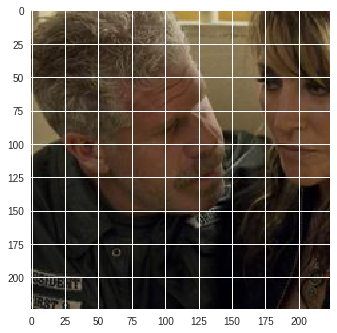

In [18]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

images, labels = load_data('dataset')

images = np.asarray(images)
images = images.astype('float32')
images /= 255
labels = np.asarray(labels)

shuffle_index = np.arange(len(images))
np.random.seed(4)
np.random.shuffle(shuffle_index)
images = images[shuffle_index]
labels = labels[shuffle_index]

labels = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33, random_state=42)

print('Number of training images: {}'.format(len(X_train)))
print('Number of testing images: {}'.format(len(X_test)))

# plot one image as example
plt.imshow(X_train[0])


**VGG16**

In [5]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.models import Model
import keras.losses

input_shape = (224, 224, 3)
num_classes = 2

vgg = VGG16(include_top=False, input_shape=input_shape)

input_layer = vgg.input

#for l in vgg.layers[0:4]:
#    l.trainable = False
    
x = vgg.layers[-1].output
x = Flatten(name="flatten")(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=input_layer, outputs=x)

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
          batch_size=32,
          epochs=30,
          verbose=1,
          validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Text(0.5,1,'Accuracy Curves')

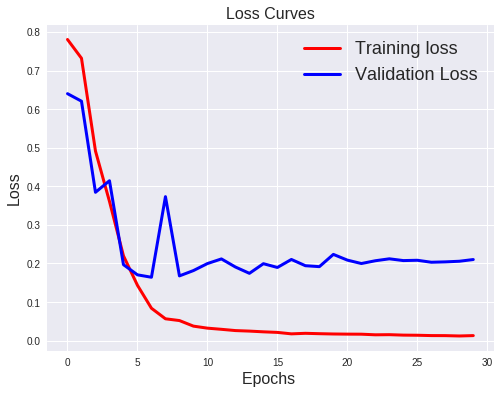

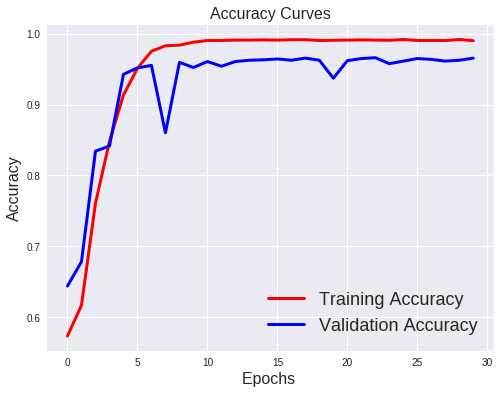

In [6]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

**CNN**

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from sklearn.model_selection import train_test_split
import keras.losses
import numpy as np
from keras.utils import to_categorical


input_shape = (224, 224, 3)
num_classes = 2

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
          batch_size=32,
          epochs=30,
          verbose=1,
          validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 3367 samples, validate on 1659 samples
Epoch 1/30
3367/3367 [==============================] - 60s 18ms/step - loss: 1.0495 - acc: 0.6953 - val_loss: 0.4462 - val_acc: 0.8077
Epoch 2/30
3367/3367 [==============================] - 53s 16ms/step - loss: 0.3440 - acc: 0.8601 - val_loss: 0.3178 - val_acc: 0.8813
Epoch 3/30
3367/3367 [==============================] - 53s 16ms/step - loss: 0.1613 - acc: 0.9471 - val_loss: 0.3095 - val_acc: 0.9011
Epoch 4/30
3367/3367 [==============================] - 53s 16ms/step - loss: 0.0993 - acc: 0.9733 - val_loss: 0.3679 - val_acc: 0.8770
Epoch 5/30
3367/3367 [==============================] - 53s 16ms/step - loss: 0.0739 - acc: 0.9840 - val_loss: 0.3221 - val_acc: 0.8915
Epoch 6/30
3367/3367 [==============================] - 53s 16ms/step - loss: 0.0586 - acc: 0.9878 - val_loss: 0.3747 - val_acc: 0.9120
Epoch 7/30
3367/3367 [==============================] - 52s 16ms/step - loss: 0.0536 - acc: 0.9893 - val_loss: 0.3504 - val_acc: 0.9060


Text(0.5,1,'Accuracy Curves')

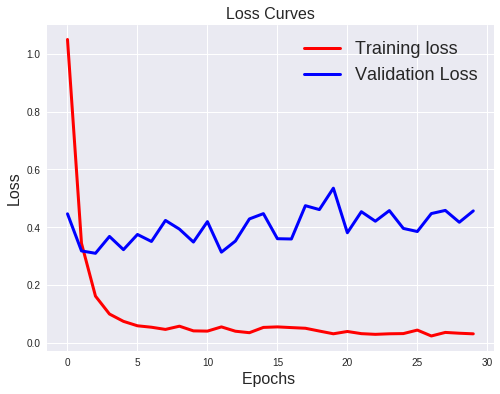

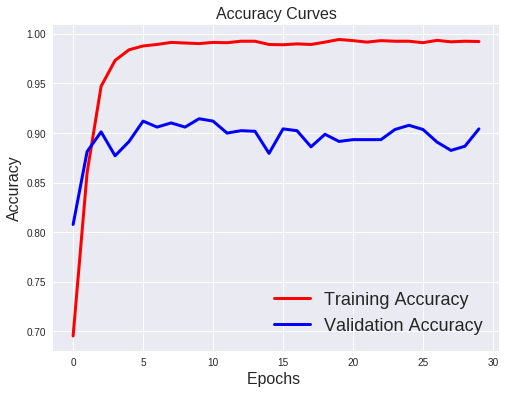

In [20]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)